## Name Analysis and forecasting

Exploration of the United States Social Security Administration babynames dataset made available via R package [babynames](http://hadley.github.io/babynames/).

* Plotting names
* Using [Prophet](https://facebook.github.io/prophet/) to forecast if popularity will continue to rise or fall

As the babynames package is in R, and I generally prefer Python, I've used the [rpy2](https://rpy2.bitbucket.io) library to pull in the appropriate portions of babynames

### To Do:

* Combine name counts based on soundex or metaphone algorithm - possibly using [Fuzzy](https://github.com/yougov/Fuzzy) or [Jellyfish](https://github.com/jamesturk/jellyfish)
* Check if name is mostly one gender or another
* Calculate probability that child with name X will have 1 or more other children with the same name in a class of 21 (number selected based on data at https://nces.ed.gov/fastfacts/display.asp?id=28, though only has public schools from 2011-2012, so may be outdated)
  * As children enter school based on birthdate around a cutoff date, would need to consider +/- 2 years
  * Should also consider regional popularity, but where to get that data?
* Compare ARIMA to Prophet for forecast - As Prophet seems to be focused on more frequent data, I'm not convinced it works well with low resolution/infrequent data such as this yearly name data. Of course, I may just not understand how to properly specify parameters to get it to work right. Some URLs with more information regarding ARIMA in python:
  * https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
  * https://blog.exploratory.io/is-prophet-better-than-arima-for-forecasting-time-series-fa9ae08a5851
* Currently just looking at data since 1990. Would including more historical data improve forecast?

In [1]:
import pandas as pd
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
# enable automatic conversion between R dataframes and Pandas Dataframes
pandas2ri.activate()

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

import matplotlib.pyplot as plt

import os
import pickle

from timeit import default_timer as timer

# to prevent some warnings later on
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
%load_ext line_profiler

In [3]:
import seaborn as sns
sns.set()
sns.set_style("ticks", {
    'axes.grid': True,
    'grid.color': '.9',
    'grid.linestyle': u'-',
    'figure.facecolor': 'white', # axes
})
sns.set_context("notebook")

**babynames:** For each year from 1880 to 2017, the number of children of each sex given each name. All names with more than 5 uses are given. (Source: http://www.ssa.gov/oact/babynames/limits.html)

**applicants:** The number of applicants for social security numbers (SSN) for each year for each sex. (Source: http://www.ssa.gov/oact/babynames/numberUSbirths.html)

**lifetables:** Cohort life tables data (Source: http://www.ssa.gov/oact/NOTES/as120/LifeTables_Body.html)

It also includes the following data set from the US Census:

**births:** Number of live births by year, up to 2017. (Source: an Excel spreadsheet from the Census that has since been removed from their website and https://www.cdc.gov/nchs/data/nvsr/nvsr66/nvsr66_01.pdf)

In [4]:
bn_filename = 'babynames.pickle'

if os.path.isfile(bn_filename):
    with open(bn_filename, 'rb') as f:
        orig_df = pickle.load(f)
else:
    bn = importr('babynames')
    orig_df = bn.__rdata__.fetch('babynames')['babynames']

    with open(bn_filename, 'wb') as f:
        pickle.dump(orig_df, f)

In [5]:
orig_df.head()

,year,sex,name,n,prop
1,1880.0,F,Mary,7065,0.072384
2,1880.0,F,Anna,2604,0.026679
3,1880.0,F,Emma,2003,0.020521
4,1880.0,F,Elizabeth,1939,0.019866
5,1880.0,F,Minnie,1746,0.017888


In [6]:
# only want to look at more recent trends
df = orig_df[orig_df.year >= 1990].copy()

In [7]:
tops = df[(df.sex == 'F') & ((df.year >= 2012) & (df.year <= 2017))].sort_values(['year', 'n'], ascending=False).groupby('year', as_index=False).head(20)
print('top femail names 2012 - 2017 by number of times in top 20 per year')
print(tops.groupby('name', as_index=False)['n'].count().sort_values('n', ascending=False))

top femail names 2012 - 2017 by number of times in top 20 per year
         name  n
0     Abigail  6
24     Sophia  6
23      Sofia  6
21     Olivia  6
5         Ava  6
6       Avery  6
7   Charlotte  6
19        Mia  6
9   Elizabeth  6
10       Ella  6
11      Emily  6
12       Emma  6
18    Madison  6
16   Isabella  6
15     Harper  5
13     Evelyn  5
8       Chloe  5
2      Amelia  5
14      Grace  3
25   Victoria  3
1     Addison  2
4      Aubrey  2
22   Scarlett  2
17       Lily  1
20    Natalie  1
3        Aria  1
26       Zoey  1


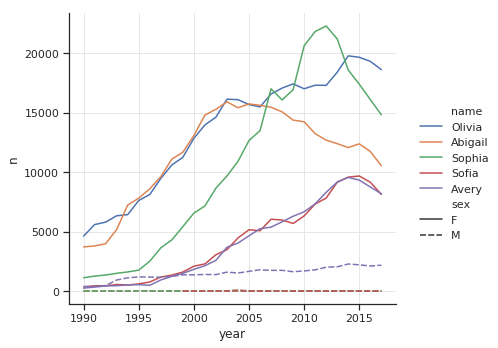

In [8]:
a = df[df.name.isin(['Abigail', 'Sophia', 'Sofia', 'Olivia', 'Avery'])]
a_plt = sns.relplot(x='year', y='n', hue='name', style='sex', kind='line', ci=None, data=a)
a_plt.fig.set_size_inches(7.5, 5)

Suppose your selected name is Sophia and soundalikes

The input to Prophet is always a dataframe with two columns: **ds** and **y**. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [9]:
# select counts without respect to gender
a = df[df.name.isin(['Sophia', 'Sofia'])]
pdf = a.groupby(['year'])['n'].sum().reset_index()
pdf.rename(columns={"year": "ds", "n": "y"}, inplace=True)
pdf['ds'] = pd.to_datetime(pdf['ds'], format='%Y')

/Users/seth/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:n_changepoints greater than number of observations.Using 21.0.
/Users/seth/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


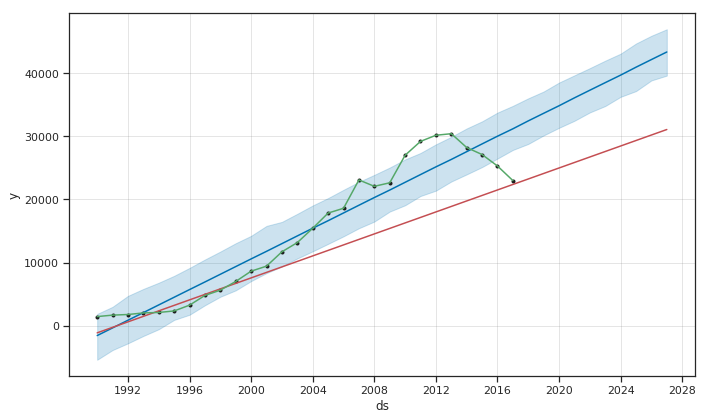

In [10]:
m = Prophet(daily_seasonality=False, weekly_seasonality=False, seasonality_mode='multiplicative')
m.fit(pdf)
# predict 10 years out
future = m.make_future_dataframe(periods=10, freq='Y')
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# show actual data in green
plt.plot(pdf.ds, pdf.y, 'g')

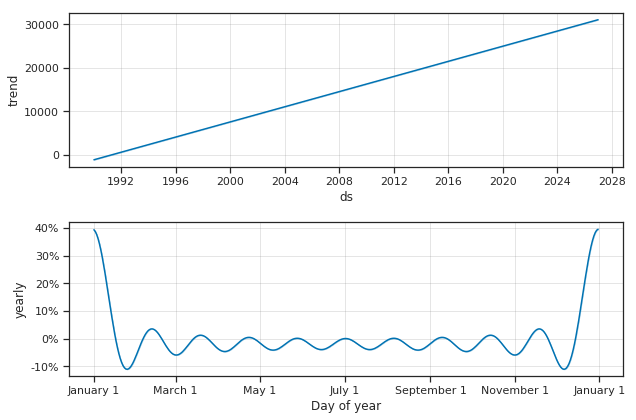

In [11]:
fig = m.plot_components(forecast)

In [12]:
df.head()

,year,sex,name,n,prop
1069606,1990.0,F,Jessica,46475,0.022627
1069607,1990.0,F,Ashley,45558,0.022181
1069608,1990.0,F,Brittany,36538,0.017789
1069609,1990.0,F,Amanda,34408,0.016752
1069610,1990.0,F,Samantha,25866,0.012593


In [13]:
df.shape

(855060, 5)

### Combine names based on how they sound

As each entry in the babynames dataset is based on spelling, evaluate different sound based algorithms to see how to combine/reduce number of names.

#### Export names file for testing/evaluation of phonetic algorithms

In [14]:
names = pd.DataFrame()
#apdf = df[['year', 'sex', 'name', 'n', 'prop']][df.year == 1990].head(100).copy()
names['name'] = df.name.unique()
print(names.shape)

with open('ssn_names_only.pickle', 'wb') as f:
    pickle.dump(names, f)

(77092, 1)


#### See the [soundconflation](soundconflation.ipynb) notebook for analysis of various phonetic algorithms.

End result is that the Abydos python library has lots of options and I like the Beider & Morse algorithm the best for the purposes of this analysis.


In [15]:
from abydos import phonetic as ap
import multiprocessing
from multiprocessing import Pool
import psutil
from functools import partial

def process_df(function, label, df_in):
    # this is is beidermorse specific; remove this function partial and you can actually parallelize
    # any method that doesn't require additional parameters
    func = partial(function, language_arg = 'english')
    df_in[label] = df_in.name.map(func)
    return df_in

def parallelize(inputdf, function, label):
    num_processes = psutil.cpu_count(logical=False)
    num_partitions = num_processes * 2 #smaller batches to get more frequent status updates (if function provides them)
    func = partial(process_df, function, label)
    with Pool(processes=num_processes) as pool:
        df_split = np.array_split(inputdf, num_partitions)
        df_out = pd.concat(pool.map(func, df_split))
    return df_out

filename = 'names_beidermorse.pickle'

if os.path.isfile(filename):
    with open(filename, 'rb') as f:
        names = pickle.load(f)
else:
    names = parallelize(names, ap.BeiderMorse().encode, 'beidermorse')
    # convert string of names space separated to a set for much faster lookup
    names['bmset'] = names['beidermorse'].str.split().apply(set)

    with open(filename, 'wb') as f:
        pickle.dump(names, f)

names.head()

,name,beidermorse,bmset
0,Jessica,zYsQki zYsiki zYsDki zisQki zisiki zisDki zYsi...,"{zisika, zisDki, zYsQko, zYsQki, zYsQka, zisQk..."
1,Ashley,izlii izlD izla izli ozlii ozlD ozla ozli azli...,"{ozlii, azli, izlii, ozli, azlii, izli, azla, ..."
2,Brittany,brQtini britini brDtini britoni brQtoni britan...,"{britini, brQtini, brQtoni, britani, britoni, ..."
3,Amanda,imindi imndi imindo imndo iminda imnda imondi ...,"{imndo, amindi, ominda, omindo, imndi, amondi,..."
4,Samantha,siminti simnti siminto simnto siminta simnta s...,"{simnti, sominta, sominti, simonti, saminti, s..."


In [16]:
checklist = names[names.name == 'Sofia'].beidermorse.values[0].split()
def check_fn(input):
    return any(x in input.split() for x in checklist)

names[names.beidermorse.map(check_fn)]

,name,beidermorse,bmset
250,Sophia,sofii sofio sofia safii safio safia,"{safii, sofio, safia, sofii, safio, sofia}"
646,Sofia,sofii sofio sofia safii safio safia,"{safii, sofio, safia, sofii, safio, sofia}"
9955,Safia,sifii sifio sifia sofii sofio sofia safii safi...,"{safii, sifia, sofio, safia, sofii, sifii, sif..."
12562,Safaa,sifii sifio sifD sifia sifoi sifoo sifoa sifai...,"{safii, sifo, sofD, sofia, safoo, sifoa, sifio..."
29240,Safiah,sifii sifio sifia sofii sofio sofia safii safi...,"{safii, sifia, sofio, safia, sofii, sifii, sif..."
40366,Saphia,sifii sifio sifia sofii sofio sofia safii safi...,"{safii, sifia, sofio, safia, sofii, sifii, sif..."
41050,Zsofia,sofii sofio sofia safii safio safia,"{safii, sofio, safia, sofii, safio, sofia}"
48433,Sofhia,sofii sofio sofia safii safio safia,"{safii, sofio, safia, sofii, safio, sofia}"
48709,Sofya,sofii sofio sofia safii safio safia,"{safii, sofio, safia, sofii, safio, sofia}"
48711,Sophya,sofii sofio sofia safii safio safia,"{safii, sofio, safia, sofii, safio, sofia}"


In [17]:
# setup test dataset
alt = df[df.year == 1990].sample(n=10, random_state=2213).copy()
alt.shape

(10, 5)

In [18]:
alt.sort_values(['year', 'sex', 'name'], inplace=True)

In [19]:
alt['counted'] = False
alt['alt_n'] = 0
alt['alt_prop'] = 0.0

In [20]:
# add another year
alt = alt.append({'year': 1991,
                  'sex': 'F',
                  'name': 'Michael',
                  'n': 42,
                  'prop': 0.000030,
                 }, ignore_index = True)
# add similar names to existing year
alt = alt.append({'year': 1990,
                  'sex': 'F',
                  'name': 'Mychael',
                  'n': 42,
                  'prop': 0.000030,
                 }, ignore_index = True)
# add similar names, different gender to existing year
alt = alt.append({'year': 1990,
                  'sex': 'M',
                  'name': 'Mychael',
                  'n': 42,
                  'prop': 0.000030,
                 }, ignore_index = True)
# if added too many times
# alt = alt.drop(alt[(alt.name == 'Michael') & (alt.n == 42)].index)
# alt = alt.drop(alt[(alt.name == 'Mychael') & (alt.n == 42)].index)

In [21]:
alt['counted'] = False
alt['alt_n'] = 0
alt['alt_prop'] = 0.0

# process each row of dataframe
def create_alt_n(row):
    print(row['name'])

    # should do no further processing if this row has already been counted
    if (row['counted'] == True):
        return

    # find matching names
    checklist = names[names.name == row['name']].beidermorse.values[0].split()
    find = lambda i: any(x in i for x in checklist)
    found = names[names.bmset.map(find)].name
    
    # aggregate count, excluding counted names, for all found names into alt_name
    alt.loc[(alt.name == row['name']) &
            (alt.year == row.year) &
            (alt.sex == row.sex) ,
            'alt_n'] = alt[(alt.name.isin(found)) & 
                           (alt.year == row.year) &
                           (alt.sex == row.sex) &
                           (alt.counted == False)]['n'].sum()
    
    # set counted flag for found names in group
    # ? how to update just group ?
    alt.loc[(alt.name.isin(found)) & (alt.year == row.year) & (alt.sex == row.sex), 'counted'] = True

gdf = alt.groupby(['year', 'sex'])
for name, group in gdf:
    g = group.sort_values('n', ascending=False).copy()
    g.apply(create_alt_n, axis=1)

# create alt_prop
def create_alt_prop(row):
    alt.loc[(alt.name == row['name']) &
            (alt.year == row.year) &
            (alt.sex == row.sex) ,
            'alt_prop'] = row['alt_n'] / gsum

for name, group in gdf:
    print(name)
    gsum = group['alt_n'].sum()
    group.apply(create_alt_prop, axis=1)    
    
alt

Michael
Mychael
Bayleigh
Leinaala
Dyesha
Latrivia
Nelson
Jeromy
Mychael
Cordarious
Shade
Kelcie
Michael
(1990.0, 'F')
(1990.0, 'M')
(1991.0, 'F')


,year,sex,name,n,prop,counted,alt_n,alt_prop
0,1990.0,F,Bayleigh,11,0.000005,True,11,0.030986
1,1990.0,F,Dyesha,8,0.000004,True,8,0.022535
2,1990.0,F,Latrivia,7,0.000003,True,7,0.019718
3,1990.0,F,Leinaala,9,0.000004,True,9,0.025352
4,1990.0,F,Michael,278,0.000135,True,320,0.901408
5,1990.0,M,Cordarious,14,0.000007,True,14,0.012511
6,1990.0,M,Jeromy,115,0.000053,True,115,0.102770
7,1990.0,M,Kelcie,6,0.000003,True,6,0.005362
8,1990.0,M,Nelson,931,0.000433,True,931,0.831993
9,1990.0,M,Shade,11,0.000005,True,11,0.009830


The above sample data set appears to be correct; now run process for all years

In [22]:
def f(name, bmset):
    return pd.DataFrame(zip([name] * len(bmset), list(bmset)), columns=('name', 'beidermorse'))
kv_names = pd.concat([f(n,b) for n, b in zip(names['name'], names['bmset'])])

In [23]:
# this is very slow look at optimizing/parallelizing
# see: https://stackoverflow.com/questions/26187759/parallelize-apply-after-pandas-groupby
# potentially look at https://github.com/jmcarpenter2/swifter
#   see realted blog post: https://medium.com/@jmcarpenter2/swiftapply-automatically-efficient-pandas-apply-operations-50e1058909f9

def calc_sound_totals(df_in):
    df_out = df_in.copy()
    df_out['counted'] = False
    df_out['alt_n'] = 0
    df_out['alt_prop'] = 0.0
    df_out['mapped_to'] = ''
    
    filt_names = kv_names.merge(df_out, on='name')[['name', 'beidermorse']]

    # process each row of dataframe
    def create_df_out_n(row):
        # should do no further processing if this row has already been counted
        if (row['counted'] == True):
            return

        #print('evaluating ', row['name'], ' ------------- ', row['counted'])
        # find matching names        
        checklist = filt_names[filt_names.name == row['name']].beidermorse.values
        found = filt_names[filt_names.beidermorse.isin(checklist)]['name'].unique()
        
        #print('after found section:\n', df_out.loc[(df_out.name.isin(found)) & (df_out.year == row.year) & (df_out.sex == row.sex)])

        # aggregate count, excluding counted names, for all found names into df_out_name
        df_out.loc[(df_out.name == row['name']) &
                (df_out.year == row.year) &
                (df_out.sex == row.sex) ,
                'alt_n'] = df_out[(df_out.name.isin(found)) & 
                               (df_out.year == row.year) &
                               (df_out.sex == row.sex) &
                               (df_out.counted == False)]['n'].sum()
        
        #print('after sum section:\n', df_out.loc[(df_out.name.isin(found)) & (df_out.year == row.year) & (df_out.sex == row.sex)])

        # set counted flag for found names in group
        # ? how to update just group ?
        df_out.loc[(df_out.name.isin(found)) & (df_out.year == row.year) & (df_out.sex == row.sex), 'counted'] = True
        df_out.loc[(df_out.name.isin(found)) & (df_out.year == row.year) & (df_out.sex == row.sex), 'mapped_to'] = row['name']
        
        #print('end of function:\n', df_out.loc[(df_out.name.isin(found)) & (df_out.year == row.year) & (df_out.sex == row.sex)])

    start = timer()
    gdf = df_out.groupby(['year', 'sex'])
    for name, group in gdf:
        print('processing name:', name)
        g = group.sort_values('n', ascending=False).copy()
        g.apply(create_df_out_n, axis=1)

    end = timer()
    print('create out_n', end - start, 'seconds')
    
    # create df_out_prop
    def create_df_out_prop(row):
        df_out.loc[(df_out.name == row['name']) &
                (df_out.year == row.year) &
                (df_out.sex == row.sex) ,
                'alt_prop'] = row['alt_n'] / gsum

    start = timer()
    for name, group in gdf:
        gsum = group['alt_n'].sum()
        group.apply(create_df_out_prop, axis=1)
    end = timer()
    print('create out_prop', end - start, 'seconds')

    return df_out

In [24]:
alt['counted'] = False
alt['alt_n'] = 0
alt['alt_prop'] = 0.0

out = calc_sound_totals(alt)

processing name: (1990.0, 'F')
processing name: (1990.0, 'M')
processing name: (1991.0, 'F')
create out_n 0.12909041400000376 seconds
create out_prop 0.0302586719999951 seconds


In [25]:
out.sort_values(['year', 'sex', 'name'])

,year,sex,name,n,prop,counted,alt_n,alt_prop,mapped_to
0,1990.0,F,Bayleigh,11,0.000005,True,11,0.030986,Bayleigh
1,1990.0,F,Dyesha,8,0.000004,True,8,0.022535,Dyesha
2,1990.0,F,Latrivia,7,0.000003,True,7,0.019718,Latrivia
3,1990.0,F,Leinaala,9,0.000004,True,9,0.025352,Leinaala
4,1990.0,F,Michael,278,0.000135,True,320,0.901408,Mychael
11,1990.0,F,Mychael,42,0.000030,True,0,0.000000,Mychael
5,1990.0,M,Cordarious,14,0.000007,True,14,0.012511,Cordarious
6,1990.0,M,Jeromy,115,0.000053,True,115,0.102770,Jeromy
7,1990.0,M,Kelcie,6,0.000003,True,6,0.005362,Kelcie
12,1990.0,M,Mychael,42,0.000030,True,42,0.037534,Mychael
